## Import

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import pandas as pd
import pathlib

# create confusion matrix
import itertools
from sklearn.metrics import confusion_matrix

## Functions

In [2]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

In [3]:
# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [4]:
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.

  Args:
    dir_path (str): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [5]:
def view_random_image(target_dir):
  target_folder = target_dir
  
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  img = mpimg.imread(target_folder + '/' + random_image[0])
  plt.imshow(img)
  plt.title(target_dir)
  plt.axis('off')

  print(f"Image shape: {img.shape}")

  return img

In [6]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

## Download the dataset

In [8]:
url = 'https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip'

zip_dir = tf.keras.utils.get_file(origin=url, extract=True)
zip_dir

'C:\\Users\\bruce\\.keras\\datasets\\pizza_steak.zip'

```
# File structure
pizza_steak <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    
```

In [10]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'pizza_steak')
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

train_pizza_dir = os.path.join(train_dir, 'pizza')  # directory with our training pizza pictures
train_steak_dir = os.path.join(train_dir, 'steak')  # directory with our training steak pictures
test_pizza_dir = os.path.join(test_dir, 'pizza')  # directory with our test pizza pictures
test_steak_dir = os.path.join(test_dir, 'steak')  # directory with our test steak pictures

num_pizza_tr = len(os.listdir(train_pizza_dir))
num_steak_tr = len(os.listdir(train_steak_dir))

num_pizza_test = len(os.listdir(test_pizza_dir))
num_steak_test = len(os.listdir(test_steak_dir))

total_train = num_pizza_tr + num_steak_tr
total_test = num_pizza_test + num_steak_test

print('total training pizza images:', num_pizza_tr)
print('total training steak images:', num_steak_tr)

print('total test pizza images:', num_pizza_test)
print('total test steak images:', num_steak_test)
print("--")
print("Total training images:", total_train)
print("Total test images:", total_test)

print("--")
data_dir = pathlib.Path(train_dir) # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

total training pizza images: 750
total training steak images: 750
total test pizza images: 250
total test steak images: 250
--
Total training images: 1500
Total test images: 500
--
['pizza' 'steak']


In [6]:
walk_through_dir(base_dir)

There are 2 directories and 0 images in 'C:\Users\bruce\.keras\datasets\pizza_steak'.
There are 2 directories and 0 images in 'C:\Users\bruce\.keras\datasets\pizza_steak\test'.
There are 0 directories and 250 images in 'C:\Users\bruce\.keras\datasets\pizza_steak\test\pizza'.
There are 0 directories and 250 images in 'C:\Users\bruce\.keras\datasets\pizza_steak\test\steak'.
There are 2 directories and 0 images in 'C:\Users\bruce\.keras\datasets\pizza_steak\train'.
There are 0 directories and 750 images in 'C:\Users\bruce\.keras\datasets\pizza_steak\train\pizza'.
There are 0 directories and 750 images in 'C:\Users\bruce\.keras\datasets\pizza_steak\train\steak'.


['608085.jpg']
Image shape: (512, 512, 3)


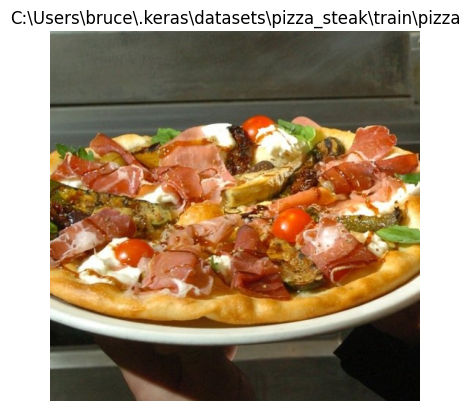

In [11]:
rand_img = view_random_image(target_dir=train_pizza_dir)

## Set ImageDataGenerator with augmentation

Found 1500 images belonging to 2 classes.


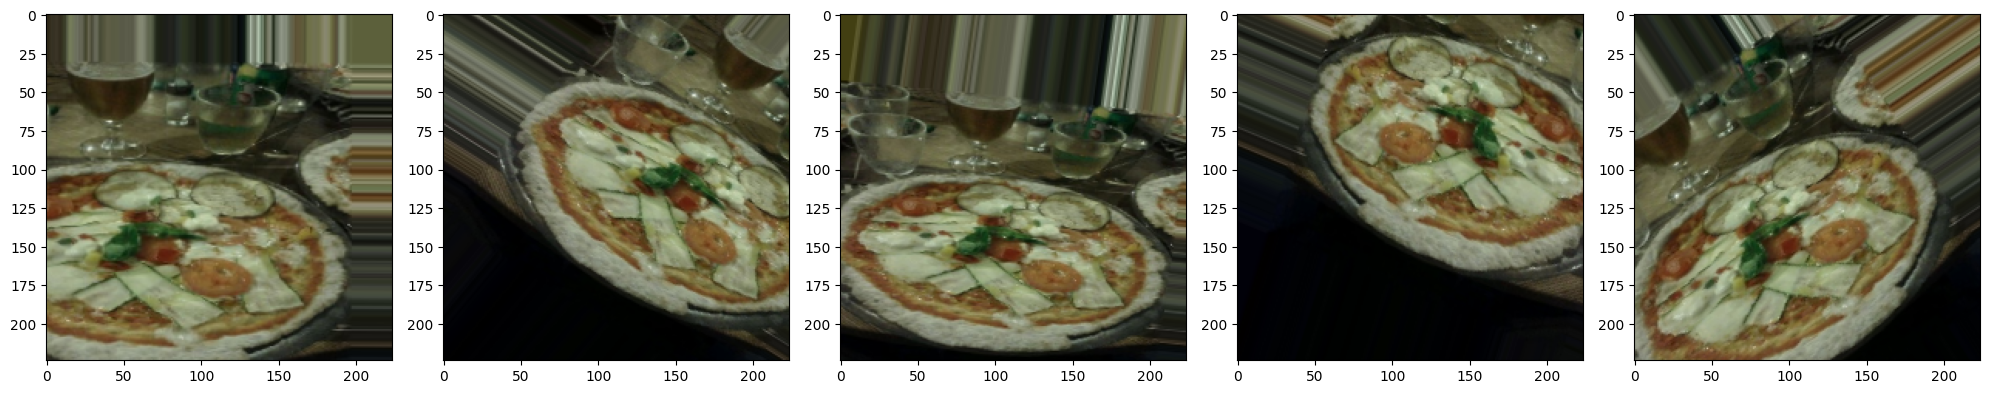

In [23]:
BATCH_SIZE = 32
IMG_SHAPE  = 224

image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_batches = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='binary'
)

augmented_images = [train_batches[0][0][0] for i in range(5)]
plotImages(augmented_images)

In [21]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_batches = image_gen_val.flow_from_directory(
    batch_size=BATCH_SIZE,
    directory=test_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='binary'
)

Found 500 images belonging to 2 classes.


## Build the model

### Get the best learning rate

In [49]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2, padding='same'),

    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2, padding='same'),

    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2, padding='same'),

    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2, padding='same'),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 20)
)

history = model.fit(
    train_batches,
    epochs=50,
    validation_data=val_batches,
    callbacks=[lr_schedule]
)

Epoch 1/50
47/47 [==============================] - 26s 540ms/step - loss: 0.6530 - accuracy: 0.6160 - val_loss: 0.5602 - val_accuracy: 0.6960 - lr: 1.0000e-04
Epoch 2/50
47/47 [==============================] - 25s 524ms/step - loss: 0.5764 - accuracy: 0.6907 - val_loss: 0.4579 - val_accuracy: 0.7980 - lr: 1.1220e-04
Epoch 3/50
47/47 [==============================] - 25s 531ms/step - loss: 0.5385 - accuracy: 0.7373 - val_loss: 0.4539 - val_accuracy: 0.8040 - lr: 1.2589e-04
Epoch 4/50
47/47 [==============================] - 25s 540ms/step - loss: 0.4817 - accuracy: 0.7807 - val_loss: 0.3414 - val_accuracy: 0.8540 - lr: 1.4125e-04
Epoch 5/50
47/47 [==============================] - 25s 529ms/step - loss: 0.4611 - accuracy: 0.7813 - val_loss: 0.3467 - val_accuracy: 0.8460 - lr: 1.5849e-04
Epoch 6/50
47/47 [==============================] - 25s 526ms/step - loss: 0.4602 - accuracy: 0.7940 - val_loss: 0.3234 - val_accuracy: 0.8580 - lr: 1.7783e-04
Epoch 7/50
47/47 [======================

### Plot the history

<Axes: xlabel='epochs'>

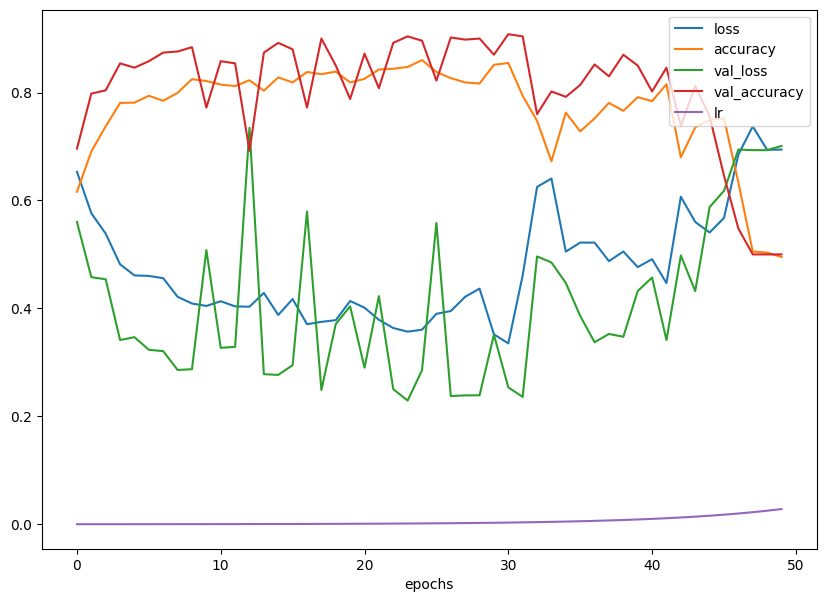

In [50]:
pd.DataFrame(history.history).plot(figsize=(10, 7), xlabel='epochs')

### Plot the Learning rate vs. Loss

Text(0.5, 1.0, 'Learning rate vs. Loss')

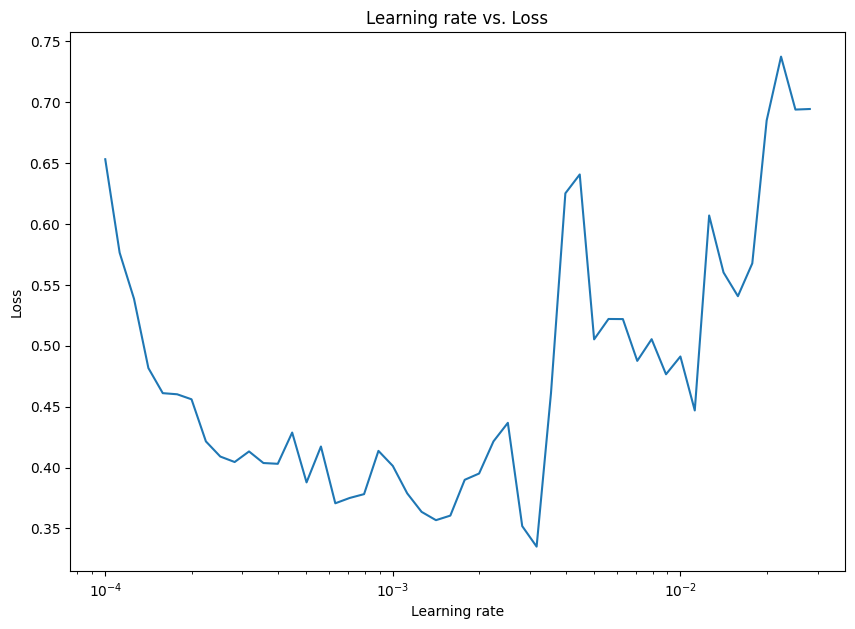

In [51]:
plt.figure(figsize=(10, 7))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.title('Learning rate vs. Loss')

### Train the Model with the best learning rate

In [52]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
    tf.keras.layers.MaxPooling2D(2, 2, padding='same'),

    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2, padding='same'),

    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2, padding='same'),

    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2, padding='same'),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    train_batches,
    epochs=20,
    validation_data=val_batches
)

Epoch 1/20
47/47 [==============================] - 27s 549ms/step - loss: 0.6728 - accuracy: 0.6167 - val_loss: 0.5558 - val_accuracy: 0.6900
Epoch 2/20
47/47 [==============================] - 27s 567ms/step - loss: 0.5559 - accuracy: 0.7207 - val_loss: 0.3623 - val_accuracy: 0.8420
Epoch 3/20
47/47 [==============================] - 26s 556ms/step - loss: 0.4884 - accuracy: 0.7620 - val_loss: 0.3744 - val_accuracy: 0.8420
Epoch 4/20
47/47 [==============================] - 26s 551ms/step - loss: 0.4530 - accuracy: 0.8007 - val_loss: 0.3040 - val_accuracy: 0.8640
Epoch 5/20
47/47 [==============================] - 26s 559ms/step - loss: 0.4229 - accuracy: 0.8073 - val_loss: 0.2725 - val_accuracy: 0.8880
Epoch 6/20
47/47 [==============================] - 26s 549ms/step - loss: 0.4001 - accuracy: 0.8240 - val_loss: 0.3594 - val_accuracy: 0.8660
Epoch 7/20
47/47 [==============================] - 26s 550ms/step - loss: 0.3974 - accuracy: 0.8240 - val_loss: 0.3067 - val_accuracy: 0.8740

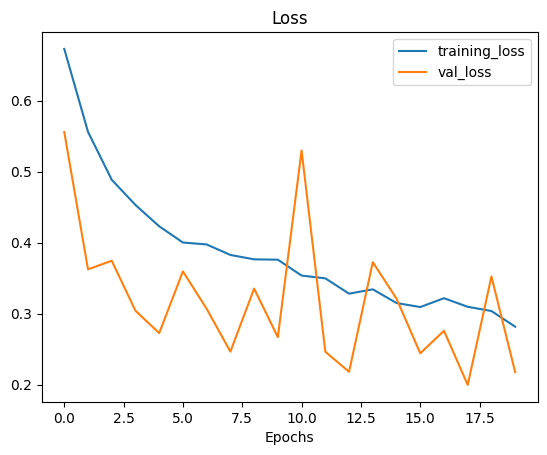

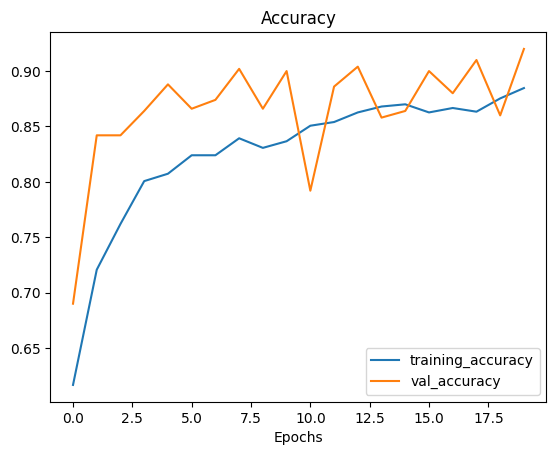

In [53]:
plot_loss_curves(history)